In [4]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.core import *
# from tensorflow.keras.layers.convolutional import *
from tensorflow.keras import backend as K
import tensorflow.compat.v1 as tf

# Initialize the setting

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = '..\\data\\SHREC\\'
C = Config()

# Building the model

In [18]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H,W],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l,joint_n,joint_d):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,joint_n*joint_d))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),joint_n*joint_d))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l,joint_n,joint_d)

    print("slow", diff_slow)
    print("fast", diff_fast)
    print("JCD", M)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # 测试删去x_d_fast
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast]) # x = concatenate([x,x_d_slow,x_d_fast])
    print('concat', x.shape)
    x = block(x,filters*2)
    print('conv1', x.shape)
    x = MaxPool1D(2)(x)
    print('pool1', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    print('conv2', x.shape)
    x = MaxPool1D(2)(x)
    print('pool2', x.shape)    
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    print('conv3', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [19]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    print('pool', x.shape)    

    x = d1D(x,128)
    print('dense1', x.shape)    

    x = Dropout(0.5)(x)
    x = d1D(x,128)
    print('dense2', x.shape)    

    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    print('dense3', x.shape)    

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [20]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)

slow Tensor("reshape_8/Identity:0", shape=(None, 32, 66), dtype=float32)
fast Tensor("reshape_9/Identity:0", shape=(None, 16, 66), dtype=float32)
JCD Tensor("input_9:0", shape=(None, 32, 231), dtype=float32)
concat (None, 16, 48)
conv1 (None, 16, 32)
pool1 (None, 8, 32)
conv2 (None, 8, 64)
pool2 (None, 4, 64)
conv3 (None, 4, 128)
pool (None, 128)
dense1 (None, 128)
dense2 (None, 128)
dense3 (None, 14)


In [67]:
DD_Net.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 231)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
model_18 (Model)                (None, 4, 128)       113696      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_9 (GlobalM (None, 128)          0           model_18[1][0]            

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [33]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:24<00:00, 80.11it/s]


In [69]:
print(X_0.shape, X_1.shape, Y.shape)

(1960, 32, 231) (1960, 32, 22, 3) (1960, 14)


In [13]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 840/840 [00:09<00:00, 88.46it/s]


In [70]:
print(X_test_0.shape, X_test_1.shape, Y_test.shape)

(840, 32, 231) (840, 32, 22, 3) (840, 14)


In [73]:
import tensorflow.keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 10s 5ms/sample - loss: 0.2446 - accuracy: 0.9316 - val_loss: 5.0073 - val_accuracy: 0.0893
Epoch 2/600
1960/1960 [==============================] - 2s 777us/sample - loss: 0.2582 - accuracy: 0.9194 - val_loss: 5.0805 - val_accuracy: 0.0821
Epoch 3/600
1960/1960 [==============================] - 2s 766us/sample - loss: 0.2613 - accuracy: 0.9255 - val_loss: 4.8437 - val_accuracy: 0.0964
Epoch 4/600
1960/1960 [==============================] - 2s 789us/sample - loss: 0.2737 - accuracy: 0.9260 - val_loss: 4.6482 - val_accuracy: 0.1036
Epoch 5/600
1960/1960 [==============================] - 1s 728us/sample - loss: 0.2448 - accuracy: 0.9281 - val_loss: 4.5795 - val_accuracy: 0.1119
Epoch 6/600
1960/1960 [==============================] - 1s 734us/sample - loss: 0.2431 - accuracy: 0.9255 - val_loss: 4.6427 - val_accuracy: 0.1119
Epoch 7/600
1960/1960 [==============================] - 1s 

Epoch 56/600
1960/1960 [==============================] - 1s 750us/sample - loss: 0.1263 - accuracy: 0.9628 - val_loss: 4.8709 - val_accuracy: 0.1500
Epoch 57/600
1960/1960 [==============================] - 1s 746us/sample - loss: 0.1226 - accuracy: 0.9617 - val_loss: 4.8561 - val_accuracy: 0.1512
Epoch 58/600
1960/1960 [==============================] - 2s 813us/sample - loss: 0.1212 - accuracy: 0.9612 - val_loss: 4.8385 - val_accuracy: 0.1512
Epoch 59/600
1960/1960 [==============================] - 1s 755us/sample - loss: 0.1183 - accuracy: 0.9668 - val_loss: 4.8398 - val_accuracy: 0.1524
Epoch 60/600
1960/1960 [==============================] - 1s 761us/sample - loss: 0.1140 - accuracy: 0.9663 - val_loss: 4.8375 - val_accuracy: 0.1536
Epoch 61/600
1960/1960 [==============================] - 1s 715us/sample - loss: 0.1287 - accuracy: 0.9648 - val_loss: 4.8340 - val_accuracy: 0.1548
Epoch 62/600
1960/1960 [==============================] - 1s 723us/sample - loss: 0.1031 - accuracy:

Epoch 111/600
1960/1960 [==============================] - 1s 732us/sample - loss: 0.1235 - accuracy: 0.9628 - val_loss: 3.6065 - val_accuracy: 0.2679
Epoch 112/600
1960/1960 [==============================] - 1s 755us/sample - loss: 0.0981 - accuracy: 0.9714 - val_loss: 3.5808 - val_accuracy: 0.2714
Epoch 113/600
1960/1960 [==============================] - 1s 750us/sample - loss: 0.1172 - accuracy: 0.9709 - val_loss: 3.5561 - val_accuracy: 0.2726
Epoch 114/600
1960/1960 [==============================] - 1s 746us/sample - loss: 0.1234 - accuracy: 0.9643 - val_loss: 3.5313 - val_accuracy: 0.2750
Epoch 115/600
1960/1960 [==============================] - 2s 767us/sample - loss: 0.1074 - accuracy: 0.9694 - val_loss: 3.5063 - val_accuracy: 0.2786
Epoch 116/600
1960/1960 [==============================] - 1s 714us/sample - loss: 0.1006 - accuracy: 0.9694 - val_loss: 3.4815 - val_accuracy: 0.2845
Epoch 117/600
1960/1960 [==============================] - 1s 703us/sample - loss: 0.0952 - ac

1960/1960 [==============================] - 1s 726us/sample - loss: 0.1013 - accuracy: 0.9745 - val_loss: 1.4223 - val_accuracy: 0.6583
Epoch 220/600
1960/1960 [==============================] - 1s 750us/sample - loss: 0.1195 - accuracy: 0.9607 - val_loss: 1.4088 - val_accuracy: 0.6631
Epoch 221/600
1960/1960 [==============================] - 2s 784us/sample - loss: 0.0959 - accuracy: 0.9730 - val_loss: 1.3953 - val_accuracy: 0.6702
Epoch 222/600
1960/1960 [==============================] - 2s 771us/sample - loss: 0.1035 - accuracy: 0.9709 - val_loss: 1.3825 - val_accuracy: 0.6750
Epoch 223/600
1960/1960 [==============================] - 1s 754us/sample - loss: 0.0884 - accuracy: 0.9776 - val_loss: 1.3697 - val_accuracy: 0.6750
Epoch 224/600
1960/1960 [==============================] - 1s 743us/sample - loss: 0.1083 - accuracy: 0.9684 - val_loss: 1.3572 - val_accuracy: 0.6774
Epoch 225/600
1960/1960 [==============================] - 1s 720us/sample - loss: 0.0991 - accuracy: 0.9679

Epoch 328/600
1960/1960 [==============================] - 2s 868us/sample - loss: 0.0978 - accuracy: 0.9750 - val_loss: 0.5422 - val_accuracy: 0.8536
Epoch 329/600
1960/1960 [==============================] - 2s 836us/sample - loss: 0.0974 - accuracy: 0.9724 - val_loss: 0.5377 - val_accuracy: 0.8560
Epoch 330/600
1960/1960 [==============================] - 2s 797us/sample - loss: 0.1003 - accuracy: 0.9724 - val_loss: 0.5332 - val_accuracy: 0.8560
Epoch 331/600
1960/1960 [==============================] - 2s 788us/sample - loss: 0.1000 - accuracy: 0.9740 - val_loss: 0.5289 - val_accuracy: 0.8560
Epoch 332/600
1960/1960 [==============================] - 1s 763us/sample - loss: 0.0962 - accuracy: 0.9755 - val_loss: 0.5246 - val_accuracy: 0.8571
Epoch 333/600
1960/1960 [==============================] - 2s 990us/sample - loss: 0.1081 - accuracy: 0.9679 - val_loss: 0.5201 - val_accuracy: 0.8571
Epoch 334/600
1960/1960 [==============================] - 2s 973us/sample - loss: 0.0850 - ac

Epoch 437/600
1960/1960 [==============================] - 2s 1ms/sample - loss: 0.0934 - accuracy: 0.9765 - val_loss: 0.2866 - val_accuracy: 0.9202
Epoch 438/600
1960/1960 [==============================] - 2s 1ms/sample - loss: 0.0948 - accuracy: 0.9750 - val_loss: 0.2858 - val_accuracy: 0.9202
Epoch 439/600
1960/1960 [==============================] - 2s 981us/sample - loss: 0.1060 - accuracy: 0.9689 - val_loss: 0.2850 - val_accuracy: 0.9214
Epoch 440/600
1960/1960 [==============================] - 2s 990us/sample - loss: 0.1068 - accuracy: 0.9679 - val_loss: 0.2843 - val_accuracy: 0.9238
Epoch 441/600
1960/1960 [==============================] - 2s 909us/sample - loss: 0.1004 - accuracy: 0.9724 - val_loss: 0.2836 - val_accuracy: 0.9226
Epoch 442/600
1960/1960 [==============================] - 2s 885us/sample - loss: 0.0884 - accuracy: 0.9730 - val_loss: 0.2828 - val_accuracy: 0.9238
Epoch 443/600
1960/1960 [==============================] - 2s 951us/sample - loss: 0.0988 - accura

Epoch 546/600
1960/1960 [==============================] - 2s 944us/sample - loss: 0.1182 - accuracy: 0.9628 - val_loss: 0.2549 - val_accuracy: 0.9333
Epoch 547/600
1960/1960 [==============================] - 2s 934us/sample - loss: 0.0921 - accuracy: 0.9765 - val_loss: 0.2549 - val_accuracy: 0.9333
Epoch 548/600
1960/1960 [==============================] - 2s 940us/sample - loss: 0.0960 - accuracy: 0.9760 - val_loss: 0.2548 - val_accuracy: 0.9333
Epoch 549/600
1960/1960 [==============================] - 2s 966us/sample - loss: 0.1036 - accuracy: 0.9709 - val_loss: 0.2547 - val_accuracy: 0.9345
Epoch 550/600
1960/1960 [==============================] - 2s 998us/sample - loss: 0.0914 - accuracy: 0.9760 - val_loss: 0.2547 - val_accuracy: 0.9345
Epoch 551/600
1960/1960 [==============================] - 2s 945us/sample - loss: 0.1018 - accuracy: 0.9719 - val_loss: 0.2546 - val_accuracy: 0.9345
Epoch 552/600
1960/1960 [==============================] - 2s 1ms/sample - loss: 0.0946 - accu

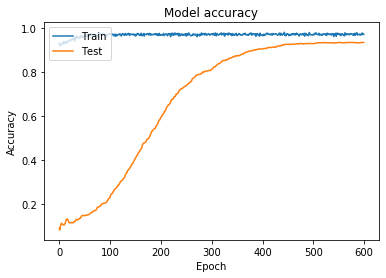

In [75]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [86]:
DD_Net.save_weights('weights/coarse_lite.h5')

## With frame_sampling

In [16]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



# Calculate time (excute it twice, the first time initialize takes extra times)

In [37]:
import time
start_time = time.time()
y = DD_Net.predict([X_0,X_1])
time.time() - start_time

0.7737669944763184

# Plot confusion matrix

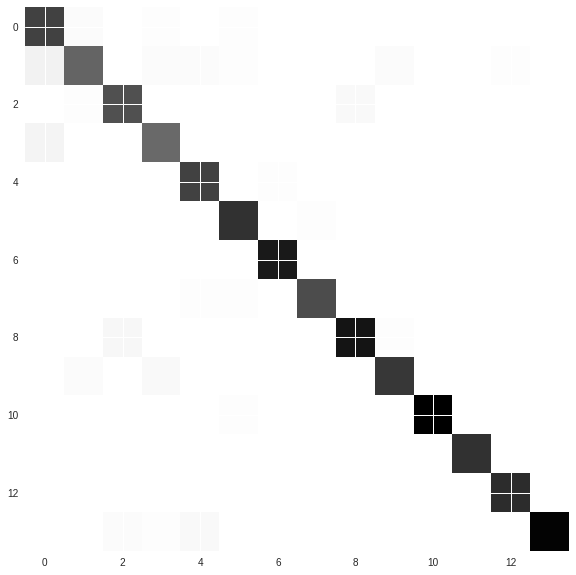

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()